## Исследование датасета IMDB Movies.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations

In [2]:
df = pd.read_csv('D:\\ds\\imdb_top_1000.csv')
pd.set_option('display.max_columns', None)

### Предобработка

In [3]:
def get_info(dataframe):
    display(dataframe.head(5))
    print()
    display(dataframe.info())
    print()
    print(f"Явных дубликатов: {dataframe.duplicated().sum()}")
    print()
    print('Пропусков в колонках:')
    print(dataframe.isna().sum())

def prep(dataframe):
    dataframe = dataframe.drop_duplicates()
    dataframe.columns = dataframe.columns.str.lower()
    return dataframe

Проведу некоторые преобразования, чтоб улучшить читаемость таблицы и подготовить данные к вычислениям.

In [4]:
df = prep(df)

In [5]:
df['gross'] = df['gross'].str.replace(',', '').astype('float64')
df['runtime'] = df['runtime'].str.replace('min', '').astype('int64')
df = df.drop(['poster_link', 'overview'], axis=1)
df['released_year'] = df['released_year'].str.replace('PG', '1995').astype('int64')

In [6]:
get_info(df)

,series_title,released_year,certificate,runtime,genre,imdb_rating,meta_score,director,star1,star2,star3,star4,no_of_votes,gross
0,The Shawshank Redemption,1994,A,142,Drama,9.3,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,28341469.0
1,The Godfather,1972,A,175,"Crime, Drama",9.2,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411.0
2,The Dark Knight,2008,UA,152,"Action, Crime, Drama",9.0,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444.0
3,The Godfather: Part II,1974,A,202,"Crime, Drama",9.0,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,57300000.0
4,12 Angry Men,1957,U,96,"Crime, Drama",9.0,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,4360000.0



<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   series_title   1000 non-null   object 
 1   released_year  1000 non-null   int64  
 2   certificate    899 non-null    object 
 3   runtime        1000 non-null   int64  
 4   genre          1000 non-null   object 
 5   imdb_rating    1000 non-null   float64
 6   meta_score     843 non-null    float64
 7   director       1000 non-null   object 
 8   star1          1000 non-null   object 
 9   star2          1000 non-null   object 
 10  star3          1000 non-null   object 
 11  star4          1000 non-null   object 
 12  no_of_votes    1000 non-null   int64  
 13  gross          831 non-null    float64
dtypes: float64(3), int64(3), object(8)
memory usage: 117.2+ KB


None


Явных дубликатов: 0

Пропусков в колонках:
series_title       0
released_year      0
certificate      101
runtime            0
genre              0
imdb_rating        0
meta_score       157
director           0
star1              0
star2              0
star3              0
star4              0
no_of_votes        0
gross            169
dtype: int64


### Исследовательсий анализ данных

#### Общее распределение наименований и сборов по годам

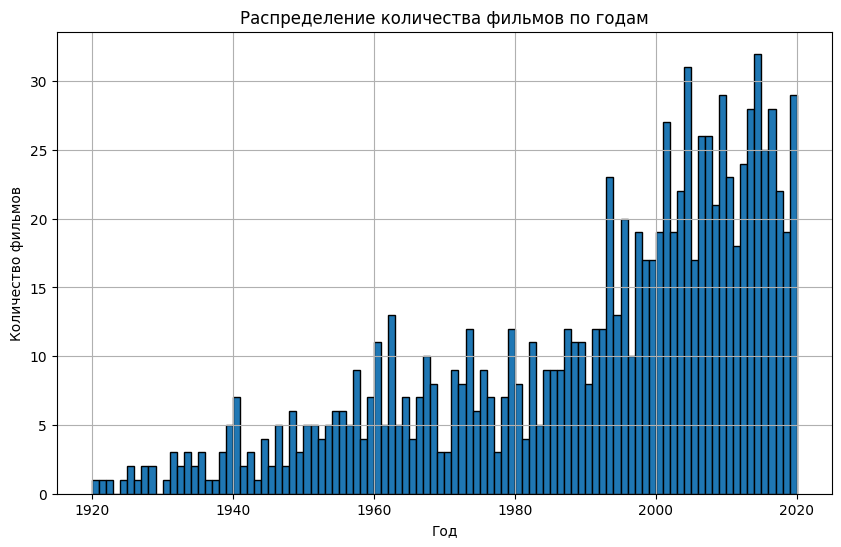

In [7]:
plt.figure(figsize=(10, 6))
df['released_year'].hist(bins=100, edgecolor='black')
plt.title(f'Распределение количества фильмов по годам')
plt.xlabel('Год')
plt.ylabel('Количество фильмов')
plt.show()

Как видно, датасет охватывает данные за период в 100 лет, в течение которого количество наименований постоянно увеличивалось. Особенно заметен рост в период 1980 - 2020.

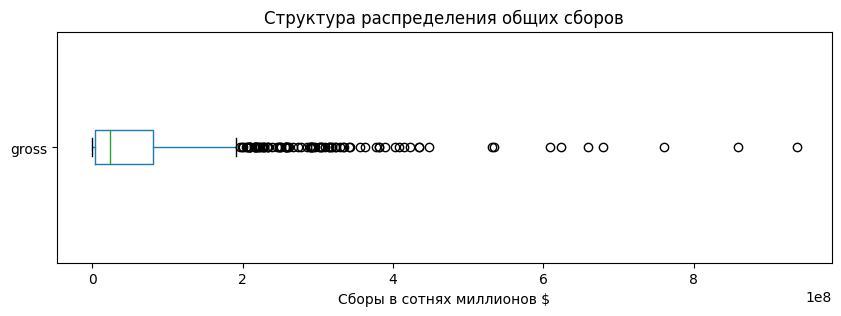

count          831.00
mean      68034750.87
std      109750043.19
min           1305.00
25%        3253559.00
50%       23530892.00
75%       80750893.50
max      936662225.00
Name: gross, dtype: object


In [60]:
plt.figure(figsize=(10, 3))
df['gross'].plot(kind='box', vert=False)
plt.title('Структура распределения общих сборов')
plt.xlabel('Сборы в сотнях миллионов $')
plt.show()
print(df['gross'].describe().apply(lambda x: format(x, '.2f')))

На боксплоте можно оценить структуру распределения сборов за весь наблюдаемый период. Медианные сборы составляют 23,5 млн, в то время как редкие наиболее выдающиеся фильмы собирают  450 - 937 млн. Посмотрим, что это за фильмы.

In [11]:
df[df['gross'] > 450000000]['series_title']

2                                 The Dark Knight
59                              Avengers: Endgame
60                         Avengers: Infinity War
357                                  The Avengers
477    Star Wars: Episode VII - The Force Awakens
582                                     Rogue One
623                                        Avatar
652                                       Titanic
891                                 Incredibles 2
Name: series_title, dtype: object

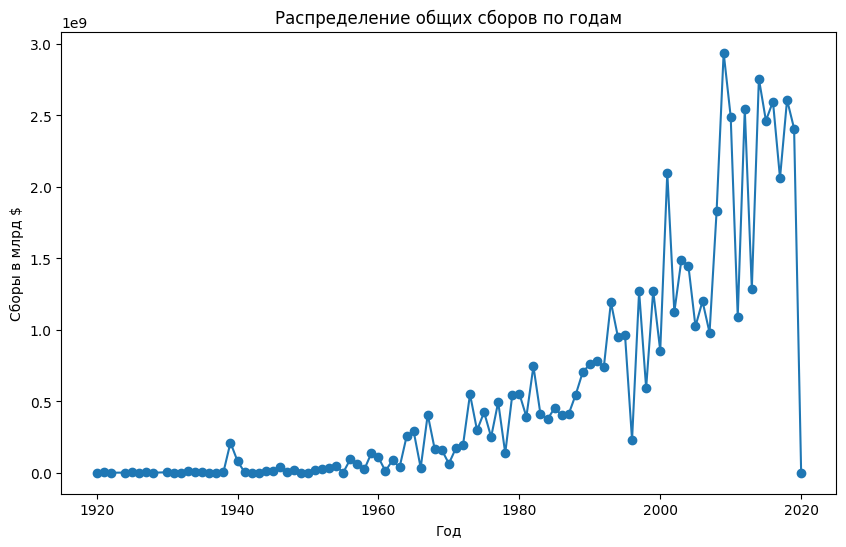

In [10]:
plt.figure(figsize=(10, 6))
df.groupby('released_year')['gross'].sum().plot(marker='o', linestyle='-')
plt.title('Распределение общих сборов по годам')
plt.xlabel('Год')
plt.ylabel('Сборы в млрд $');

График общих сборов в целом похож на график количества фильмов. Сборы в номинальном выражении растут схожим образом в течение наблюдаемого периода.

#### Определение кассовости и популярности режиссеров

In [15]:
top15_dir_gross = df.groupby('director')['gross'].sum().sort_values(ascending=False).head(15)
director_gross_slice = df.query('director in @top15_dir_gross.index')

Для исследования берутся первые 15 режиссеров по суммарным сборам.

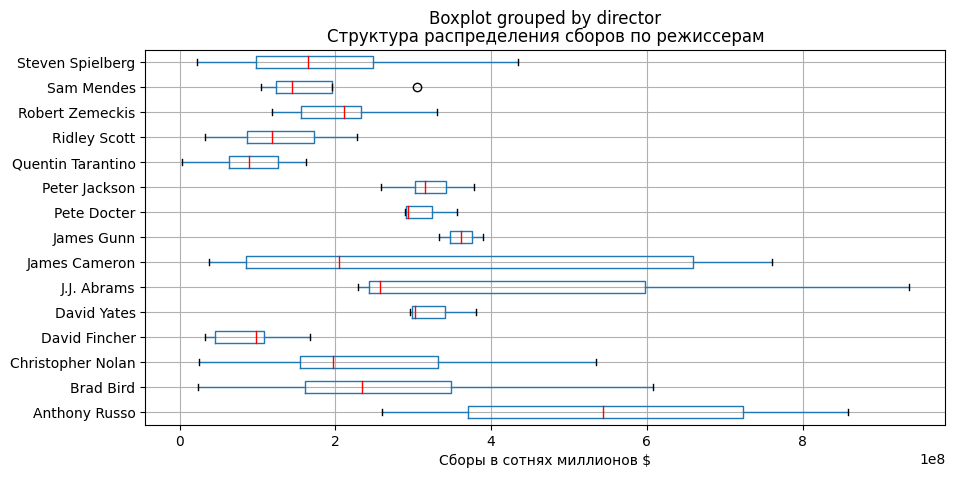

In [16]:
director_gross_slice.boxplot(by='director', column='gross', figsize=(10, 5), vert=False, medianprops=dict(color='red'))
plt.title('Структура распределения сборов по режиссерам')
plt.xlabel('Сборы в сотнях миллионов $')
plt.show();

По отметке медианы можно определить наиболее успешных режиссеров, в среднем выдающих более кассовые фильмы. Здесь следует отметить, что сравнивать таким образом всех режиссеров за последние 100 лет, конечно, не корректно. Надо учитывать, что одна денежная единица может иметь разный вес в разных временных периодах, а также каждый временной период имеет свои характерные значения кассовых сборов. Для корректного сравнения требуется определить актуальный временной период и делать сравнение в его рамках, но в данной работе, которая выполняется в свободном формате, этого проводиться не будет. 

In [17]:
director_gross_slice.groupby('director')['gross'].describe()

,count,mean,std,min,25%,50%,75%,max
director,,,,,,,,
Anthony Russo,4.0,5.512599e+08,2.683632e+08,259766572.0,3.710049e+08,543449915.5,7.237049e+08,858373000.0
Brad Bird,4.0,2.749069e+08,2.446658e+08,23159305.0,1.606241e+08,233943373.0,3.482263e+08,608581744.0
Christopher Nolan,8.0,2.421818e+08,1.774349e+08,25544867.0,1.542875e+08,197612796.5,3.314669e+08,534858444.0
David Fincher,8.0,8.916431e+07,4.711590e+07,33080084.0,4.550026e+07,98544168.5,1.087642e+08,167767189.0
David Yates,3.0,3.263179e+08,4.745995e+07,295983305.0,2.989713e+08,301959197.0,3.414852e+08,381011219.0
J.J. Abrams,3.0,4.743903e+08,4.006009e+08,228778661.0,2.432543e+08,257730019.0,5.971961e+08,936662225.0
James Cameron,5.0,3.496473e+08,3.363418e+08,38400000.0,8.516025e+07,204843350.0,6.593254e+08,760507625.0
James Gunn,2.0,3.614949e+08,4.004805e+07,333176600.0,3.473357e+08,361494850.5,3.756540e+08,389813101.0
Pete Docter,3.0,3.131274e+08,3.756038e+07,289916256.0,2.914602e+08,293004164.0,3.247329e+08,356461711.0


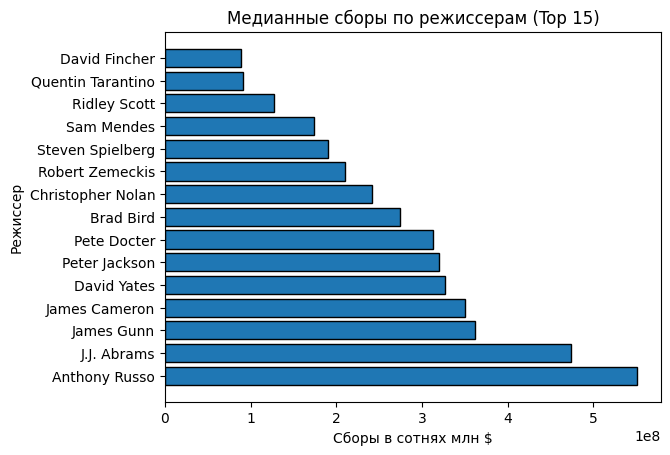

In [18]:
director_gross_mean = director_gross_slice.groupby('director')['gross'].mean().sort_values(ascending=False)
plt.barh(director_gross_mean.index, director_gross_mean.values, edgecolor='black')
plt.title('Медианные сборы по режиссерам (Top 15)')
plt.xlabel('Сборы в сотнях млн $')
plt.ylabel('Режиссер');

Визуализация медианных сборов по режиссерам.

In [124]:
top15_dir_votes = df.groupby('director')['no_of_votes'].sum().sort_values(ascending=False).head(15)
director_votes_slice = df.query('director in @top15_dir_votes.index')

Для исследования популярности режиссеров берутся первые 15 по количеству полученных голосов от пользователей IMDB.

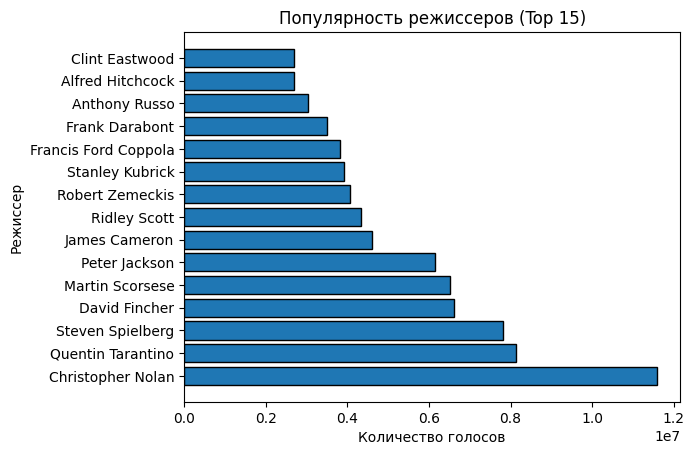

In [129]:
director_votes_sum = director_votes_slice.groupby('director')['no_of_votes'].sum().sort_values(ascending=False)
plt.barh(director_votes_sum.index, director_votes_sum.values, edgecolor='black')
plt.title('Популярность режиссеров (Top 15)')
plt.xlabel('Количество голосов')
plt.ylabel('Режиссер');

Визуализация распределения суммарных голосов по режиссерам.

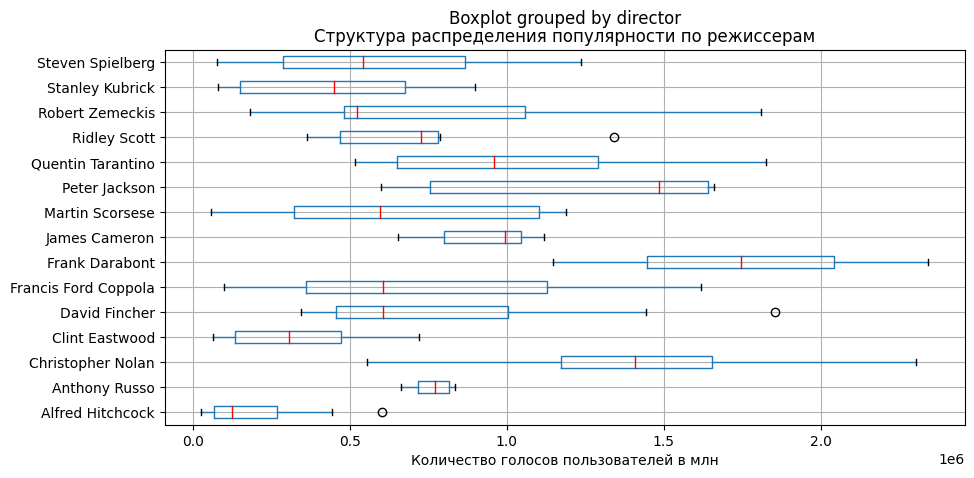

In [135]:
director_votes_slice.boxplot(by='director', column='no_of_votes', figsize=(10, 5), vert=False, medianprops=dict(color='red'))
plt.title('Структура распределения популярности по режиссерам')
plt.xlabel('Количество голосов пользователей в млн')
plt.show();

По отметке медианы на боксплоте можно определить режиссеров, к которым публика в среднем проявляет больше интереса. Выдающиеся точки у некоторых режиссеров означают наличие работ с нехарактерно высоким для них вниманием публики.

#### Определение кассовости и популярности актеров

In [138]:
df.pivot_table(index=['star1', 'star2'], values='gross', aggfunc='sum').sort_values(by='gross', ascending=False).head(15)

,,gross
star1,star2,
Joe Russo,Robert Downey Jr.,1.537188e+09
Daniel Radcliffe,Emma Watson,1.518325e+09
Tom Hanks,Tim Allen,1.040839e+09
Daisy Ridley,John Boyega,9.366622e+08
Mark Hamill,Harrison Ford,9.223406e+08
Sam Worthington,Zoe Saldana,7.605076e+08
Joe Russo,Chris Evans,6.678509e+08
Leonardo DiCaprio,Kate Winslet,6.593254e+08
Elijah Wood,Ian McKellen,6.580961e+08


Первые 15 комбинаций исполнителей двух главных ролей, которые суммарно принесли больше кассовых сборов.

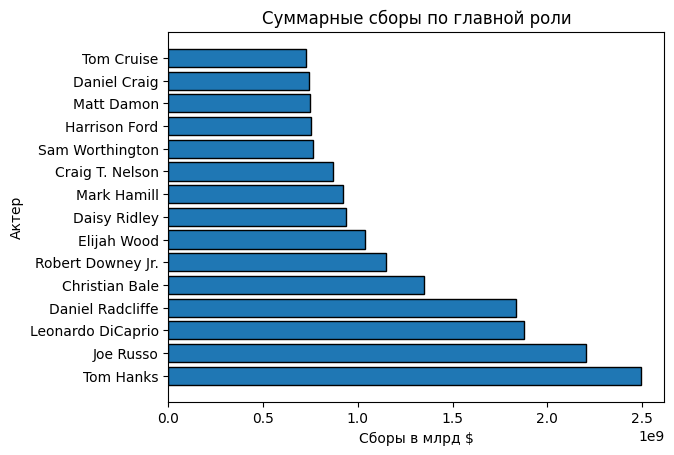

In [169]:
star1_gross_sum = df.groupby('star1')['gross'].sum().sort_values(ascending=False).head(15)
plt.barh(star1_gross_sum.index, star1_gross_sum.values, edgecolor='black')
plt.title('Суммарные сборы по главной роли')
plt.xlabel('Сборы в млрд $')
plt.ylabel('Актер');

Первые 15 актеров, чьё исполнение главной роли принесло наибольшие суммарные кассовые сборы фильмам.

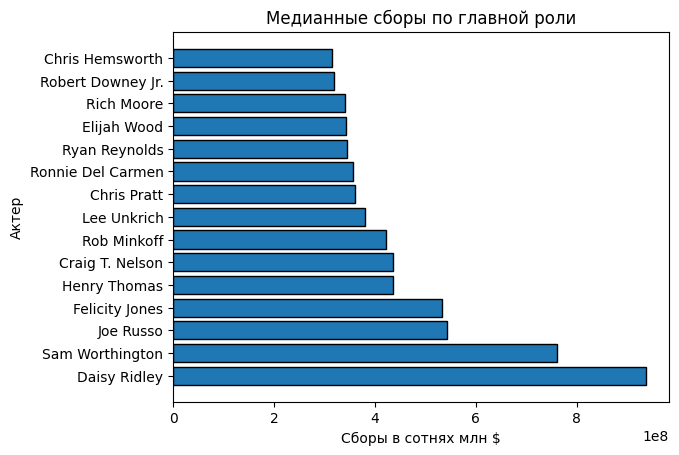

In [175]:
star1_gross_median = df.groupby('star1')['gross'].median().sort_values(ascending=False).head(15)
plt.barh(star1_gross_median.index, star1_gross_median.values, edgecolor='black')
plt.title('Медианные сборы по главной роли')
plt.xlabel('Сборы в сотнях млн $')
plt.ylabel('Актер');

То же самое, но с медианным значением. Тут наглядна разница между суммированием сборов и вычислением медианы по всему наблюдаемому периоду. Tom Hanks, имеющий наибольшие суммарные сборы за всё время, не попадает даже в топ 15 актеров, имеющих наиболее высокий средний результат. Происходит это из-за большого количества фильмов, снятых в разные временные периоды, в которых он играл главную роль.

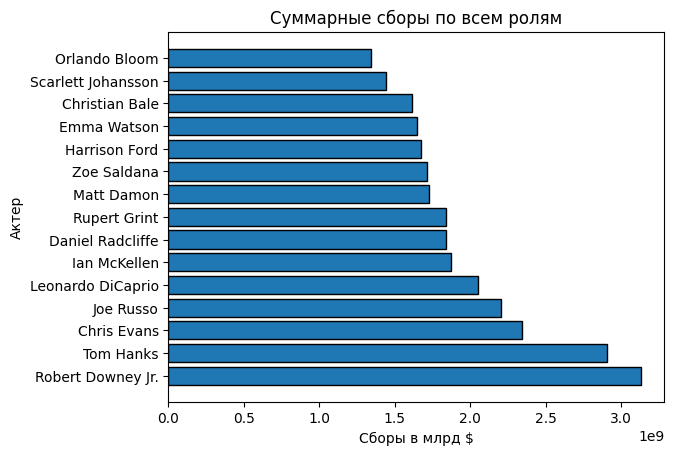

In [181]:
actor_gross_dict = {}

for index, row in df.iterrows():
    for i in range(1, 5):
        actor = row[f'star{i}']
        gross = row['gross']
        actor_gross_dict[actor] = actor_gross_dict.get(actor, 0) + gross
        
actor_gross_df = pd.DataFrame(list(actor_gross_dict.items()), columns=['actor', 'gross']).sort_values(by='gross', ascending=False).head(15)
plt.barh(actor_gross_df['actor'], actor_gross_df['gross'], edgecolor='black')
plt.title('Суммарные сборы по всем ролям')
plt.xlabel('Сборы в млрд $')
plt.ylabel('Актер');
plt.show()

На этом графике визуализация первых 15 актеров по суммарным сборам, учитывающая не только их главную роль, но и любую из 4 ролей, представленных в датасете.

In [182]:
df.pivot_table(index=['star1', 'star2'], values='no_of_votes', aggfunc='sum').sort_values(by='no_of_votes', ascending=False).head(15)

,,no_of_votes
star1,star2,
Mark Hamill,Harrison Ford,3341258
Elijah Wood,Ian McKellen,3147036
Daniel Radcliffe,Emma Watson,2819552
Tim Robbins,Morgan Freeman,2343110
Christian Bale,Heath Ledger,2303232
Leonardo DiCaprio,Joseph Gordon-Levitt,2067042
Brad Pitt,Edward Norton,1854740
Tom Hanks,Tim Allen,1847638
John Travolta,Uma Thurman,1826188


Первые 15 комбинаций исполнителей главных ролей, имеющих наибольшее внимание публики.

In [184]:
top15_act_votes = df.groupby('star1')['no_of_votes'].sum().sort_values(ascending=False).head(15)
actor_votes_slice = df.query('star1 in @top15_act_votes.index')

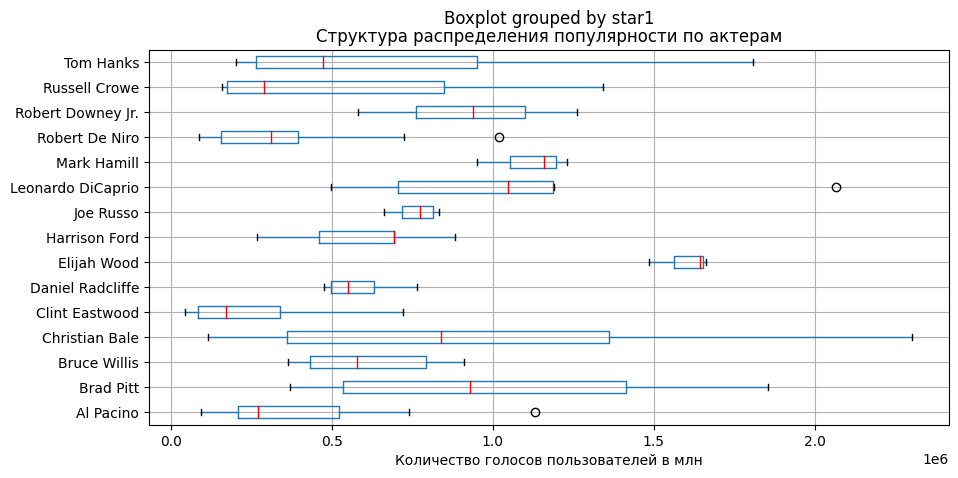

In [186]:
actor_votes_slice.boxplot(by='star1', column='no_of_votes', figsize=(10, 5), vert=False, medianprops=dict(color='red'))
plt.title('Структура распределения популярности по актерам')
plt.xlabel('Количество голосов пользователей в млн')
plt.show();

На боксплоте можно увидеть среднее внимание публики к работам актера, а так же наличие нехарактерно выдающихся работ.

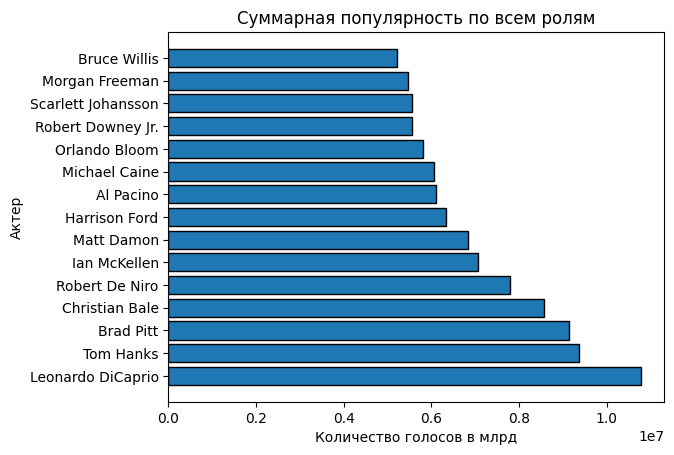

In [22]:
actor_votes_dict = {}

for index, row in df.iterrows():
    for i in range(1, 5):
        actor = row[f'star{i}']
        votes = row['no_of_votes']
        actor_votes_dict[actor] = actor_votes_dict.get(actor, 0) + votes
        
actor_votes_df = pd.DataFrame(list(actor_votes_dict.items()), columns=['actor', 'votes']).sort_values(by='votes', ascending=False).head(15)
plt.barh(actor_votes_df['actor'], actor_votes_df['votes'], edgecolor='black')
plt.title('Суммарная популярность по всем ролям')
plt.xlabel('Количество голосов в млрд')
plt.ylabel('Актер');
plt.show()

Первые 15 по популярности актеров, с учетом их появления не только в главной роли.

#### Определение наиболее характерных жанров для актеров

Для исследования возьму список из предыдущей визуализации.

In [192]:
top15_actors = actor_votes_df['actor']

In [211]:
actor_genres_count = {}

for actor in top15_actors:
    actor_movies = df[(df['star1'] == actor) | (df['star2'] == actor) | (df['star3'] == actor) | (df['star4'] == actor)]
    genres = actor_movies['genre'].str.split(', ').explode()
    genre_count = genres.value_counts()
    actor_genres_count[actor] = genre_count

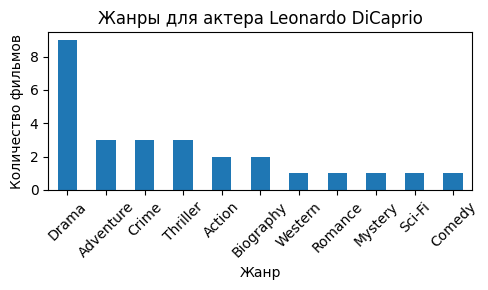

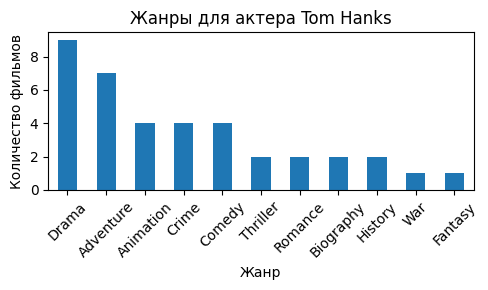

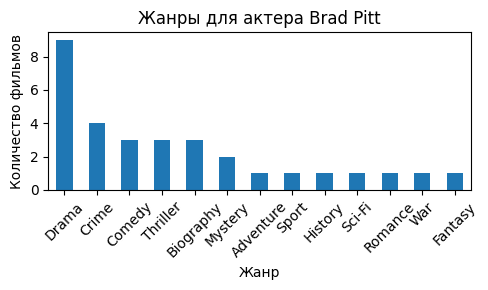

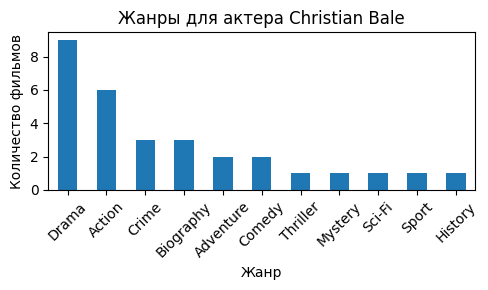

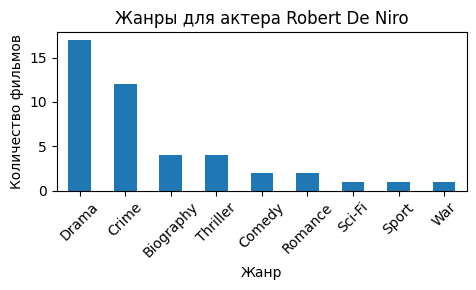

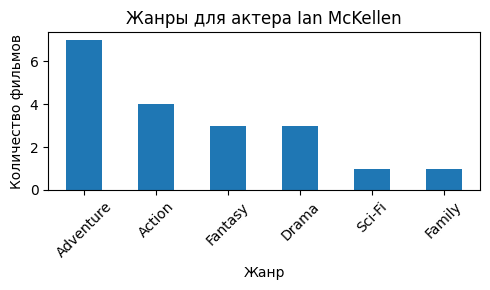

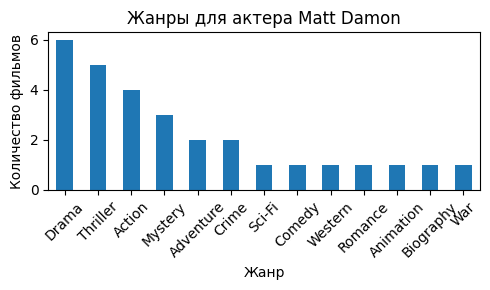

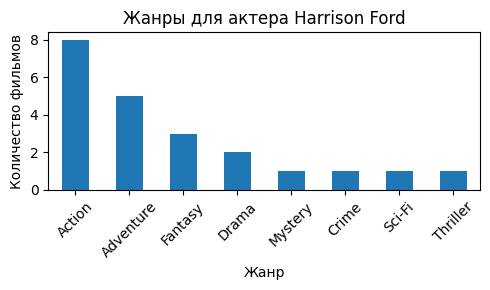

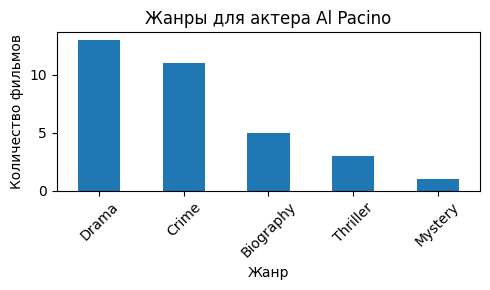

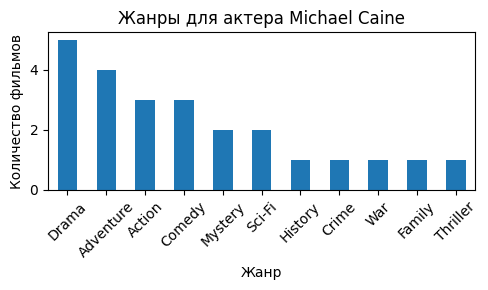

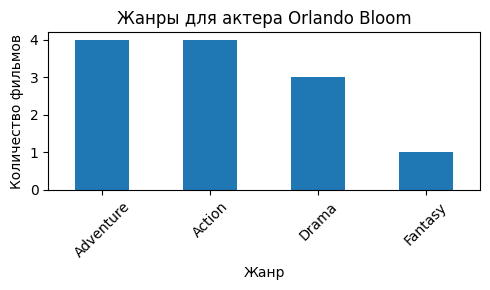

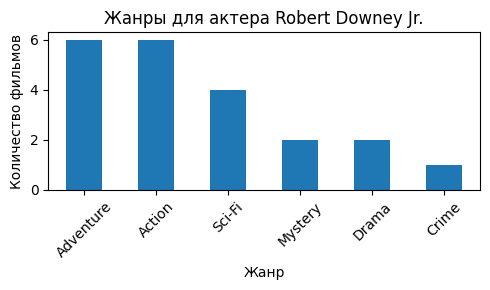

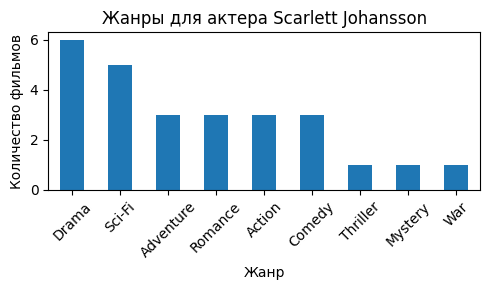

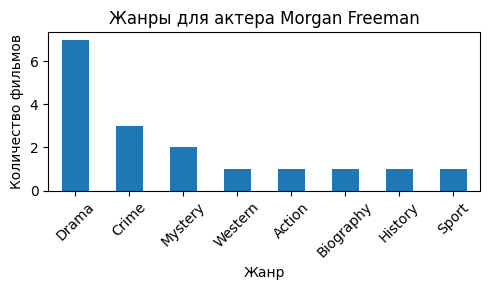

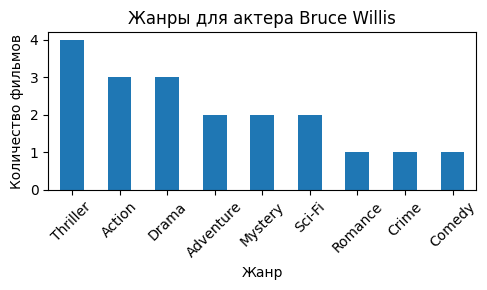

In [212]:
for actor, genre_count in actor_genres_count.items():
    plt.figure(figsize=(5, 3))
    genre_count.plot(kind='bar')
    plt.title(f'Жанры для актера {actor}')
    plt.xlabel('Жанр')
    plt.ylabel('Количество фильмов')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#### Определение зависимости между некоторыми характеристиками фильмов

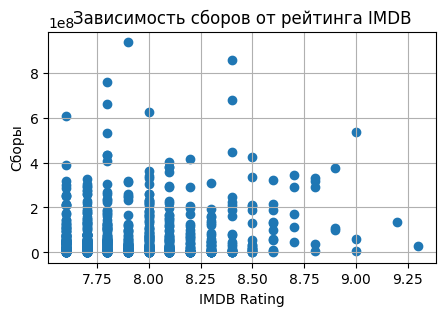

Корреляция между сборами и рейтингом IMDB: 0.09592277110132354


In [220]:
plt.figure(figsize=(5, 3))
plt.scatter(df['imdb_rating'], df['gross'])
plt.title('Зависимость сборов от рейтинга IMDB')
plt.xlabel('IMDB Rating')
plt.ylabel('Сборы')
plt.grid(True)
plt.show()
print(f"Корреляция между сборами и рейтингом IMDB: {df['gross'].corr(df['imdb_rating'])}")

Корреляция между сборами и рейтингом IMDB близка к нулю. Сборы не зависят от рейтинга.

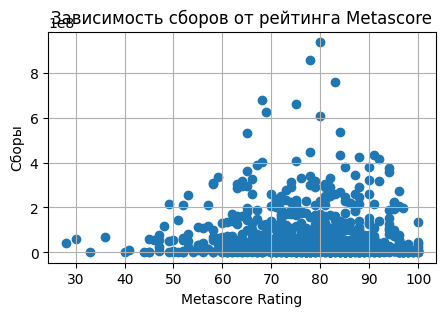

Корреляция между сборами и рейтингом Metascore: -0.03058704333449355


In [222]:
plt.figure(figsize=(5, 3))
plt.scatter(df['meta_score'], df['gross'])
plt.title('Зависимость сборов от рейтинга Metascore')
plt.xlabel('Metascore Rating')
plt.ylabel('Сборы')
plt.grid(True)
plt.show()
print(f"Корреляция между сборами и рейтингом Metascore: {df['gross'].corr(df['meta_score'])}")

Корреляция между сборами и рейтингом Metascore близка к нулю. Сборы не зависят от рейтинга.

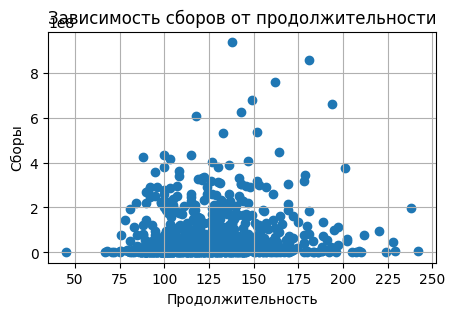

Корреляция между сборами и продолжительностью: 0.1396706906569775


In [12]:
plt.figure(figsize=(5, 3))
plt.scatter(df['runtime'], df['gross'])
plt.title('Зависимость сборов от продолжительности')
plt.xlabel('Продолжительность')
plt.ylabel('Сборы')
plt.grid(True)
plt.show()
print(f"Корреляция между сборами и продолжительностью: {df['gross'].corr(df['runtime'])}")

Корреляция между сборами и продолжительностью фильма отлична от нуля, но существенно меньше среднего. Сборы не зависят от продолжительности.

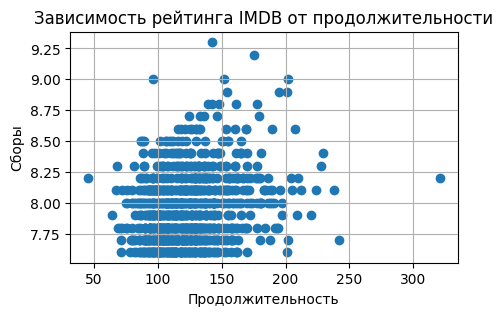

Корреляция между рейтингом IMDB и продолжительностью: 0.2430958977541943


In [13]:
plt.figure(figsize=(5, 3))
plt.scatter(df['runtime'], df['imdb_rating'])
plt.title('Зависимость рейтинга IMDB от продолжительности')
plt.xlabel('Продолжительность')
plt.ylabel('Сборы')
plt.grid(True)
plt.show()
print(f"Корреляция между рейтингом IMDB и продолжительностью: {df['imdb_rating'].corr(df['runtime'])}")

Корреляция между рейтингом IMDB и продолжительностью меньше среднего. Рейтинг IMDB не зависит от продолжительности фильма.